## Plotting for Fig 3. cross sections normalised 
- original cross section code from Taimoor Sohail
- code for Fig. S2 at the end - Hovmöller diagram

In [1]:
%matplotlib inline
# Load necessary modules
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import cmocean.cm as cmocean
import glob
import matplotlib.path as mpath
import matplotlib.colors as col
import pandas as pd
import scipy.stats as stats
from tqdm import tqdm
import logging
import matplotlib.cm as cm
from xhistogram.xarray import histogram

logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client


In [2]:
from dask.distributed import Client,LocalCluster


In [3]:
client = Client() # n_workers=4
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/36903/status,
Dashboard: /proxy/36903/status,Workers: 7
Total threads: 28,Total memory: 126.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38477,Workers: 7
Dashboard: /proxy/36903/status,Total threads: 28
Started: Just now,Total memory: 126.00 GiB
Comm: tcp://127.0.0.1:42027,Total threads: 4
Dashboard: /proxy/40895/status,Memory: 18.00 GiB
Nanny: tcp://127.0.0.1:37709,


2024-12-03 15:35:09,121 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-155960026fbb505c8e4cc36d129cdcf0',): 'forgotten'}


In [4]:
session = cc.database.create_session()
# Define experiment in database
expt = '01deg_jra55v13_ryf9091'


In [5]:
lat_slice = slice(-80,-59)


# Import bathymetry - t-grid
ht = cc.querying.getvar(expt, 'ht', session, n=1)
ht = ht.sel(yt_ocean=lat_slice)
# Import bathymetry - u-grid
hu = cc.querying.getvar(expt, 'hu', session, n=1)
hu = hu.sel(yu_ocean=lat_slice)


In [6]:

## CHANGE THE EXPERIMENT NAME HERE
expt = '01deg_jra55v13_ryf9091_qian_wthmp'


### CHANGE THE DECADE YOU ARE TESTING HERE
start_time='2150-01-01 00:00:00'
end_time='2159-12-31 00:00:00'

# Import properties to average
temp = cc.querying.getvar(expt, 'temp', session, start_time=start_time, end_time=end_time, attrs={'cell_methods': 'time: mean'}, frequency='1 monthly')#, ncfile="ocean.nc")
temp = temp.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
salt = cc.querying.getvar(expt, 'salt', session, start_time=start_time, end_time=end_time, frequency='1 monthly')#, ncfile="ocean.nc")
salt = salt.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
density = cc.querying.getvar(expt, 'pot_rho_0', session, start_time=start_time, end_time=end_time, frequency='1 monthly')#, ncfile="ocean.nc")
density = density.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
u = cc.querying.getvar(expt, 'u', session, start_time=start_time, end_time=end_time, frequency='1 monthly')#, ncfile="ocean.nc")
u = u.sel(time=slice(start_time,end_time)).sel(yu_ocean=lat_slice)


age = cc.querying.getvar(expt, 'age_global', session, start_time=start_time, end_time=end_time )#, ncfile="ocean.nc")
age = age.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/dataset.py:274: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/dataset.py:274: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/dataset.py:274: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3

In [7]:
%%time
# thickness / area for depth averaging (not time varying):

xt_ocean = cc.querying.getvar(expt,'xt_ocean' , session,n=1)
yt_ocean = cc.querying.getvar(expt,'yt_ocean' , session,n=1)
yt_ocean = yt_ocean.sel(yt_ocean=lat_slice)
# import edges of st_ocean and add lat/lon dimensions:
st_edges_ocean = cc.querying.getvar(expt, 'st_edges_ocean', session, n=1)
st_edges_array = st_edges_ocean.expand_dims({'yt_ocean':yt_ocean,'xt_ocean':xt_ocean}, axis=[1,2])

st_edges_with_partial = st_edges_array.where(st_edges_array<ht, other=ht)
thickness = st_edges_with_partial.diff(dim='st_edges_ocean')

# change coordinate of thickness to st_ocean (needed for multipling with other variables):
st_ocean = cc.querying.getvar(expt, 'st_ocean', session, n=1)
thickness['st_edges_ocean'] = st_ocean.values
thickness = thickness.rename(({'st_edges_ocean':'st_ocean'}))

# area for area averaging:

area_t = cc.querying.getvar(expt,'area_t',session,n=1)
area_t = area_t.sel(yt_ocean=lat_slice)

volume = area_t*thickness
volume = volume.load()



CPU times: user 13.7 s, sys: 8.34 s, total: 22 s
Wall time: 23.7 s


In [8]:
%%time
# thickness / area for depth averaging (not time varying):

xu_ocean = cc.querying.getvar(expt,'xu_ocean' , session,n=1)
yu_ocean = cc.querying.getvar(expt,'yu_ocean' , session,n=1)
yu_ocean = yu_ocean.sel(yu_ocean=lat_slice)
# import edges of st_ocean and add lat/lon dimensions:
st_edges_ocean = cc.querying.getvar(expt, 'st_edges_ocean', session, n=1)
st_edges_array = st_edges_ocean.expand_dims({'yu_ocean':yu_ocean,'xu_ocean':xu_ocean}, axis=[1,2])

st_edges_with_partial = st_edges_array.where(st_edges_array<hu, other=hu)
thickness_u = st_edges_with_partial.diff(dim='st_edges_ocean')

# change coordinate of thickness to st_ocean (needed for multipling with other variables):
st_ocean = cc.querying.getvar(expt, 'st_ocean', session, n=1)
thickness_u['st_edges_ocean'] = st_ocean.values
thickness_u = thickness_u.rename(({'st_edges_ocean':'st_ocean'}))

# area for area averaging:

area_u = cc.querying.getvar(expt,'area_u',session,n=1)
area_u = area_u.sel(yu_ocean=lat_slice)

volume_u = area_u*thickness_u
volume_u = volume_u.load()


CPU times: user 14.4 s, sys: 9.01 s, total: 23.4 s
Wall time: 25 s


## Load and average data starting from here -  skip if data is already saved

In [ ]:
%%time
bins_isobath = st_edges_ocean.values
# make histogram of height/depth ht, weighted by values of volume/T/S in xy space, into bins defined by how deep each point is (bins = bins_isobath).

V_sum = histogram(ht, bins = bins_isobath, dim = ['yt_ocean', 'xt_ocean'], weights = volume)
Vu_sum = histogram(hu, bins = bins_isobath, dim = ['yu_ocean', 'xu_ocean'], weights = volume_u)

A_sum = histogram(ht, bins = bins_isobath, dim = ['yt_ocean', 'xt_ocean'], weights = area_t)
#lat-lon area of tracer --- to get the effective area of water column at each isobath depth
Au_sum = histogram(hu, bins = bins_isobath, dim = ['yu_ocean', 'xu_ocean'], weights = area_u)

TV_sum = histogram(ht, bins = bins_isobath, dim = ['yt_ocean', 'xt_ocean'], weights = volume*temp)
SV_sum = histogram(ht, bins = bins_isobath, dim = ['yt_ocean', 'xt_ocean'], weights = volume*salt)
rhoV_sum = histogram(ht, bins = bins_isobath, dim = ['yt_ocean', 'xt_ocean'], weights = volume*density)

uV_sum = histogram(hu, bins = bins_isobath, dim = ['yu_ocean', 'xu_ocean'], weights = volume_u*u)

T_mean = TV_sum/V_sum
S_mean = SV_sum/V_sum
rho_mean = rhoV_sum/V_sum
u_mean = uV_sum/Vu_sum

T_mean.load()

rho_mean.load()
S_mean.load()
u_mean.load()


In [ ]:
ageV_sum = histogram(ht, bins = bins_isobath, dim = ['yt_ocean', 'xt_ocean'], weights = volume*age)
age_mean = ageV_sum/V_sum

age_mean.load()

In [189]:
## save data with appropriate names given decade chosen -comment out accordingly
#age_mean.to_netcdf('age_mean_dec0.nc') # year 2110-2120
#age_mean.to_netcdf('age_mean_dec30.nc') # year 2130-2140
age_mean.to_netcdf('age_mean_dec50.nc') # year 2150-2160


In [32]:
rho_mean.load()
S_mean.load()
u_mean.load()

<xarray.DataArray 'histogram_hu' (st_ocean: 75, time: 120, hu_bin: 75)> Size: 5MB
array([[[        nan,         nan,         nan, ...,  0.04332782,
          0.04600806,  0.06650874],
        [        nan,         nan,         nan, ...,  0.04194948,
          0.05278199,  0.04134756],
        [        nan,         nan,         nan, ...,  0.06619285,
          0.07661873,  0.07446453],
        ...,
        [        nan,         nan,         nan, ...,  0.08042327,
          0.08882528,  0.08060593],
        [        nan,         nan,         nan, ...,  0.06849956,
          0.08433243,  0.09853641],
        [        nan,         nan,         nan, ...,  0.0434363 ,
          0.05500471,  0.06728433]],

       [[        nan,         nan,         nan, ...,  0.0324091 ,
          0.03236957,  0.04981074],
        [        nan,         nan,         nan, ...,  0.03424851,
          0.04145448,  0.03309864],
        [        nan,         nan,         nan, ...,  0.05037208,
          0.05821956,  0.05818434],
...
        [        nan,         nan,         nan, ...,         nan,
                 nan,  0.00142396],
        [        nan,         nan,         nan, ...,         nan,
                 nan,  0.00218688],
        [        nan,         nan,         nan, ...,         nan,
                 nan,  0.00123096]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]])
Coordinates:
  * hu_bin   (hu_bin) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
Dimensions without coordinates: st_ocean, time

In [33]:
expt

'01deg_jra55v13_ryf9091_qian_wthmp'

In [36]:
## save data with appropriate names given decade chosen -comment out accordingly

'''
T_mean.to_netcdf('T_mean_dec50.nc') # year 2150-2159
S_mean.to_netcdf('S_mean_dec50.nc')
rho_mean.to_netcdf('rho_mean_dec50.nc')
u_mean.to_netcdf('u_mean_dec50.nc')
'''
T_mean.to_netcdf('T_mean_dec30.nc') # year 2130-2140
S_mean.to_netcdf('S_mean_dec30.nc')
rho_mean.to_netcdf('rho_mean_dec30.nc')
u_mean.to_netcdf('u_mean_dec30.nc')
'''
T_mean.to_netcdf('T_mean_dec0.nc') # year 2110-2120
S_mean.to_netcdf('S_mean_dec0.nc')
rho_mean.to_netcdf('rho_mean_dec0.nc')
u_mean.to_netcdf('u_mean_dec0.nc')
'''

"\nT_mean.to_netcdf('T_mean_dec0.nc') # year 2110-2120\nS_mean.to_netcdf('S_mean_dec0.nc')\nrho_mean.to_netcdf('rho_mean_dec0.nc')\nu_mean.to_netcdf('u_mean_dec0.nc')\n"

## saving control experiment data - skip if already done

In [ ]:
expt = '01deg_jra55v13_ryf9091'
start_time='2110-01-01 00:00:00'
end_time='2119-12-31 00:00:00'

age = cc.querying.getvar(expt, 'age_global', session, start_time=start_time, end_time=end_time )#, ncfile="ocean.nc")
age = age.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)

ageV_sum = histogram(ht, bins = bins_isobath, dim = ['yt_ocean', 'xt_ocean'], weights = volume*age)
age_mean = ageV_sum/V_sum
#age_mean.load()


u = cc.querying.getvar(expt, 'u', session, start_time=start_time, end_time=end_time )#, ncfile="ocean.nc")
u = u.sel(time=slice(start_time,end_time)).sel(yu_ocean=lat_slice)

uV_sum = histogram(hu, bins = bins_isobath, dim = ['yu_ocean', 'xu_ocean'], weights = volume_u*u)
u_mean = uV_sum/Vu_sum
u_mean.load()

u_mean.to_netcdf('u_mean_ctrldec0.nc') # year 2110-2120


In [19]:
volume.load()

<xarray.DataArray (yt_ocean: 483, xt_ocean: 3600, st_ocean: 75)> Size: 1GB
array([[[              nan,               nan,               nan, ...,
                       nan,               nan,               nan],
        [              nan,               nan,               nan, ...,
                       nan,               nan,               nan],
        [              nan,               nan,               nan, ...,
                       nan,               nan,               nan],
        ...,
        [              nan,               nan,               nan, ...,
                       nan,               nan,               nan],
        [              nan,               nan,               nan, ...,
                       nan,               nan,               nan],
        [              nan,               nan,               nan, ...,
                       nan,               nan,               nan]],

       [[              nan,               nan,               nan, ...,
                       nan,               nan,               nan],
        [              nan,               nan,               nan, ...,
                       nan,               nan,               nan],
        [              nan,               nan,               nan, ...,
                       nan,               nan,               nan],
...
        [35331710.0736632 , 39045319.22676219, 43149222.03132311, ...,
                0.        ,        0.        ,        0.        ],
        [35331710.0736632 , 39045319.22676219, 43149222.03132311, ...,
                0.        ,        0.        ,        0.        ],
        [35331710.0736632 , 39045319.22676219, 43149222.03132311, ...,
                0.        ,        0.        ,        0.        ]],

       [[35437649.54506565, 39162393.6754939 , 43278601.72350033, ...,
                0.        ,        0.        ,        0.        ],
        [35437649.54506565, 39162393.6754939 , 43278601.72350033, ...,
                0.        ,        0.        ,        0.        ],
        [35437649.54506565, 39162393.6754939 , 43278601.72350033, ...,
                0.        ,        0.        ,        0.        ],
        ...,
        [35437649.54506565, 39162393.6754939 , 43278601.72350033, ...,
                0.        ,        0.        ,        0.        ],
        [35437649.54506565, 39162393.6754939 , 43278601.72350033, ...,
                0.        ,        0.        ,        0.        ],
        [35437649.54506565, 39162393.6754939 , 43278601.72350033, ...,
                0.        ,        0.        ,        0.        ]]])
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 4kB -79.97 -79.93 -79.88 ... -59.08 -59.03
    geolon_t  (yt_ocean, xt_ocean) float32 7MB nan nan nan ... 79.75 79.85 79.95
    geolat_t  (yt_ocean, xt_ocean) float32 7MB nan nan nan ... -59.03 -59.03
  * st_ocean  (st_ocean) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03

In [23]:

temp = cc.querying.getvar(expt, 'temp', session, start_time=start_time, end_time=end_time , attrs={'cell_methods': 'time: mean'}, frequency='1 monthly')#, ncfile="ocean.nc")
temp = temp.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
TV_sum = histogram(ht, bins = bins_isobath, dim = ['yt_ocean', 'xt_ocean'], weights = volume*temp)
T_mean = TV_sum/V_sum

salt = cc.querying.getvar(expt, 'salt', session, start_time=start_time, end_time=end_time , frequency='1 monthly')#, ncfile="ocean.nc")
SV_sum = histogram(ht, bins = bins_isobath, dim = ['yt_ocean', 'xt_ocean'], weights = volume*salt)
S_mean = SV_sum/V_sum

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/dataset.py:274: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/dataset.py:274: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/dataset.py:274: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3

In [25]:
V_sum.load()

<xarray.DataArray 'histogram_ht' (st_ocean: 75, ht_bin: 75)> Size: 45kB
array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        9.02757032e+11, 1.21208277e+11, 8.43952823e+09],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        9.97643092e+11, 1.33948112e+11, 9.32658151e+09],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.10250151e+12, 1.48026881e+11, 1.03068625e+10],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        6.95398939e+13, 2.21366477e+13, 1.54133751e+12],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 8.15238881e+12, 1.54438807e+12],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 1.63482317e+12, 6.39568553e+11]])
Coordinates:
  * ht_bin   (ht_bin) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
Dimensions without coordinates: st_ocean

In [ ]:
S_mean.load()
S_mean.to_netcdf('S_mean_ctrldec0.nc')

## probably seperate into different cells to avoid memory errors
T_mean.load()
T_mean.to_netcdf('T_mean_ctrldec0.nc')

In [23]:
density = cc.querying.getvar(expt, 'pot_rho_0', session, start_time=start_time, end_time=end_time )#, ncfile="ocean.nc")
density = density.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
rhoV_sum = histogram(ht, bins = bins_isobath, dim = ['yt_ocean', 'xt_ocean'], weights = volume*density)
rho_mean = rhoV_sum/V_sum

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/xarray/core/dataset.py:277: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/xarray/core/dataset.py:277: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/xarray/core/dataset.py:277: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3

In [ ]:
rho_mean.load()
rho_mean.to_netcdf('rho0_mean_ctrldec0.nc')

In [38]:
u_mean_ctrl_0 = xr.open_mfdataset('u_mean_ctrldec0.nc').sel(hu_bin = slice(0,3000), st_ocean = slice(0,60) )
rho_mean_ctrl_0 = xr.open_mfdataset('rho0_mean_ctrldec0.nc').sel(ht_bin = slice(0,3000), st_ocean = slice(0,60) )
S_mean_ctrl_0 = xr.open_mfdataset('S_mean_ctrldec0.nc').sel(ht_bin = slice(0,3000), st_ocean = slice(0,60) )
T_mean_ctrl_0 = xr.open_mfdataset('T_mean_ctrldec0.nc').sel(ht_bin = slice(0,3000), st_ocean = slice(0,60) )


In [40]:
age_mean_ctrl_50 = xr.open_mfdataset('age_mean_ctrldec50.nc').sel(ht_bin = slice(0,3000), st_ocean = slice(0,60) )
age_mean_ctrl_30 = xr.open_mfdataset('age_mean_ctrldec30.nc').sel(ht_bin = slice(0,3000), st_ocean = slice(0,60) )
age_mean_ctrl_0 = xr.open_mfdataset('age_mean_ctrldec0.nc').sel(ht_bin = slice(0,3000), st_ocean = slice(0,60) )


In [41]:
age_diff_0 = (age_mean_0.mean('time').histogram_ht.values - age_mean_ctrl_0.mean('time').histogram_ht.values)
age_diff_30 = (age_mean_30.mean('time').histogram_ht.values - age_mean_ctrl_30.mean('time').histogram_ht.values)
age_diff_50 = (age_mean_50.mean('time').histogram_ht.values - age_mean_ctrl_50.mean('time').histogram_ht.values)

## Plotting all times with importing

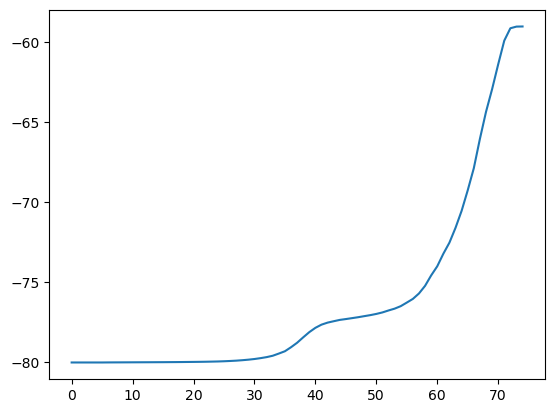

In [9]:
## import vol and areas for plotting
bins_isobath = st_edges_ocean.values
# make histogram of height/depth ht, weighted by values of volume/T/S in xy space, into bins defined by how deep each point is (bins = bins_isobath).

V_sum = histogram(ht, bins = bins_isobath, dim = ['yt_ocean', 'xt_ocean'], weights = volume)
Vu_sum = histogram(hu, bins = bins_isobath, dim = ['yu_ocean', 'xu_ocean'], weights = volume_u)

A_sum = histogram(ht, bins = bins_isobath, dim = ['yt_ocean', 'xt_ocean'], weights = area_t)
#lat-lon area of tracer --- to get the effective area of water column at each isobath depth
Au_sum = histogram(hu, bins = bins_isobath, dim = ['yu_ocean', 'xu_ocean'], weights = area_u)
normalised_area_cumsum = A_sum.cumsum('ht_bin')/np.nansum(A_sum)
normalised_area_cumsum_u = Au_sum.cumsum('hu_bin')/np.nansum(Au_sum)

pseudo_lat = -1*(80-(80-59)*normalised_area_cumsum)
plt.plot(pseudo_lat.values)

In [10]:
cd /g/data/v45/qo9901/MW-perturb-ASC-data

/g/data/v45/qo9901/MW-perturb-ASC-data


In [22]:
u_mean_ctrl_0 = xr.open_mfdataset('u_mean_ctrldec0.nc').sel(hu_bin = slice(0,3000), st_ocean = slice(0,60) )
rho_mean_ctrl_0 = xr.open_mfdataset('rho0_mean_ctrldec0.nc').sel(ht_bin = slice(0,3000), st_ocean = slice(0,60) )
S_mean_ctrl_0 = xr.open_mfdataset('S_mean_ctrldec0.nc').sel(ht_bin = slice(0,3000), st_ocean = slice(0,60) )
T_mean_ctrl_0 = xr.open_mfdataset('T_mean_ctrldec0.nc').sel(ht_bin = slice(0,3000), st_ocean = slice(0,60) )


In [11]:
age_mean_50 = xr.open_mfdataset('age_mean_dec50.nc').sel(ht_bin = slice(0,3000), st_ocean = slice(0,60) )
age_mean_30 = xr.open_mfdataset('age_mean_dec30.nc').sel(ht_bin = slice(0,3000), st_ocean = slice(0,60) )
age_mean_0 = xr.open_mfdataset('age_mean_dec0.nc').sel(ht_bin = slice(0,3000), st_ocean = slice(0,60) )


In [12]:
T_mean_50 = xr.open_mfdataset('T_mean_dec50.nc').sel(ht_bin = slice(0,3000), st_ocean = slice(0,60) ) # year 2150-2159
S_mean_50 = xr.open_mfdataset('S_mean_dec50.nc').sel(ht_bin = slice(0,3000), st_ocean = slice(0,60) )
rho_mean_50 = xr.open_mfdataset('rho_mean_dec50.nc').sel(ht_bin = slice(0,3000), st_ocean = slice(0,60) )
u_mean_50 = xr.open_mfdataset('u_mean_dec50.nc').sel(hu_bin = slice(0,3000), st_ocean = slice(0,60) )

T_mean_30 = xr.open_mfdataset('T_mean_dec30.nc').sel(ht_bin = slice(0,3000), st_ocean = slice(0,60) ) # year 2130-2140
S_mean_30 = xr.open_mfdataset('S_mean_dec30.nc').sel(ht_bin = slice(0,3000), st_ocean = slice(0,60) )
rho_mean_30 = xr.open_mfdataset('rho_mean_dec30.nc').sel(ht_bin = slice(0,3000), st_ocean = slice(0,60) )
u_mean_30 = xr.open_mfdataset('u_mean_dec30.nc').sel(hu_bin = slice(0,3000), st_ocean = slice(0,60) )

T_mean_0 = xr.open_mfdataset('T_mean_dec0.nc').sel(ht_bin = slice(0,3000), st_ocean = slice(0,60) ) # year 2110-2120
S_mean_0 = xr.open_mfdataset('S_mean_dec0.nc').sel(ht_bin = slice(0,3000), st_ocean = slice(0,60) )
rho_mean_0 = xr.open_mfdataset('rho_mean_dec0.nc').sel(ht_bin = slice(0,3000), st_ocean = slice(0,60) )
u_mean_0 = xr.open_mfdataset('u_mean_dec0.nc').sel(hu_bin = slice(0,3000), st_ocean = slice(0,60) )


In [14]:
def fmt(x):
    s = f"{x:.2f}"
    #if s.endswith("0"):
    #    s = f"{x:.0f}"
    return rf"{s} \m/s" if plt.rcParams["text.usetex"] else f"{s} m/s"

def fmt_rho(x):
    s = f"{x:.2f}"
    #if s.endswith("0"):
    #    s = f"{x:.0f}"
    return rf"{s}" if plt.rcParams["text.usetex"] else f"{s} "


In [15]:
from matplotlib import rc
rc('font', **{'size':35})
rc('text', usetex=False)
rc('xtick', labelsize=35) #20 
rc('ytick', labelsize=35) #20
rc('axes', titlesize=35)    # fontsize of the axes title
rc('axes', labelsize=35) #24    # fontsize of the x and y labels

In [16]:
def plot_topography_isobath(bins_isobath, ax):
    # Example topography and distance arrays
    '''
    topography = generate_cross_section_depth(hu_region.drop(['geolon_c', 'geolat_c']),\
                                               shelf_coord, depth_coord) # Replace with actual topography data
    topography = topography.to_dataframe().set_index(['distance']).to_xarray().hu
    
    distance = u_section.distance  # Replace with actual distance data
    '''
    ax.plot(normalised_area_cumsum, bins_isobath[:60],color = 'g',lw = 4)
                            
    # Specified depth
    specified_depth = 600  # Example: depth in meters
    
    # Find the index where the topography is closest to the specified depth
    #index = np.argmin(np.abs(topography - specified_depth))
    index = np.abs(bins_isobath - specified_depth).argmin()#.values#kipna = True
    normalised_area_cumsum_depth = normalised_area_cumsum[index]
    
    ax.axvline(x=normalised_area_cumsum_depth, color='g', lw =4 ,linestyle='--', label=f'Depth: {specified_depth}m')
    # Specified depth
    specified_depth = 200  # Example: depth in meters
    
    # Find the index where the topography is closest to the specified depth
    #index = np.argmin(np.abs(topography - specified_depth))
    index = np.abs(bins_isobath - specified_depth).argmin()#.values#kipna = True
    normalised_area_cumsum_depth = normalised_area_cumsum[index]
    
    ax.axvline(x=normalised_area_cumsum_depth, color='gray', lw =4 ,linestyle='--', label=f'Depth: {specified_depth}m')
    
    # Specified depth
    specified_depth = 1000  # Example: depth in meters
    
    # Find the index where the topography is closest to the specified depth
    #index = np.argmin(np.abs(topography - specified_depth))
    index = np.abs(bins_isobath - specified_depth).argmin()#.values#kipna = True
    normalised_area_cumsum_depth = normalised_area_cumsum[index]
    
    ax.axvline(x=normalised_area_cumsum_depth, color='gray', lw =4 ,linestyle='--', label=f'Depth: {specified_depth}m')
      # Specified depth
    specified_depth = 2500  # Example: depth in meters
    
    # Find the index where the topography is closest to the specified depth
    #index = np.argmin(np.abs(topography - specified_depth))
    index = np.abs(bins_isobath - specified_depth).argmin()#.values#kipna = True
    normalised_area_cumsum_depth = normalised_area_cumsum[index]
    
    ax.axvline(x=normalised_area_cumsum_depth, color='g', lw =4 ,linestyle='--', label=f'Depth: {specified_depth}m')
    return

In [17]:
normalised_area_cumsum = A_sum.sel(ht_bin = slice(0,3000)).cumsum('ht_bin')/np.nansum(A_sum.sel(ht_bin = slice(0,3000)))
normalised_area_cumsum_u = Au_sum.sel(hu_bin = slice(0,3000)).cumsum('hu_bin')/np.nansum(Au_sum.sel(hu_bin = slice(0,3000)))


In [24]:
normalised_area_cumsum.load(), normalised_area_cumsum_u.load()

(<xarray.DataArray 'histogram_ht' (ht_bin: 60)> Size: 240B
 array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 6.00286468e-04, 9.85930790e-04,
        1.23197993e-03, 1.55352091e-03, 1.92274735e-03, 2.24116561e-03,
        2.51232274e-03, 2.80967937e-03, 3.19636310e-03, 3.47690796e-03,
        4.00223490e-03, 4.43334039e-03, 5.05466713e-03, 5.83000667e-03,
        6.55384967e-03, 7.38014700e-03, 8.46279413e-03, 9.97178815e-03,
        1.15783829e-02, 1.40541550e-02, 1.71797201e-02, 2.09067930e-02,
        2.60596499e-02, 3.21580879e-02, 3.98126803e-02, 4.97695692e-02,
        6.15439825e-02, 7.72993788e-02, 1.02448635e-01, 1.29057080e-01,
        1.75024867e-01, 2.26418152e-01, 2.88648546e-01, 3.48447144e-01,
        3.97920310e-01, 4.34509069e-01, 4.57797825e-01, 4.73857045e-01,
        4.89133984e-01, 4.98762757e-01, 5.09256482e-01, 5.19801795e-01,
        5.31918526e-01, 5.43786645e-01, 5.57749033e-01, 5.74910581e-01,
     

In [18]:
st_ocean = st_ocean.sel(st_ocean = slice(0,3000))

## Final plots

In [19]:
import cmocean

In [20]:

vmin_rho = 0.7
vmax_rho = 0.9
levels_rho = np.linspace(vmin_rho, vmax_rho,5)
levels_rho

array([0.7 , 0.75, 0.8 , 0.85, 0.9 ])

[0.7 0.8 0.9]
[0.7 0.8 0.9]
[0.7 0.8 0.9]
[0.7 0.8 0.9]
[0.7 0.8 0.9]


Text(0.07, 2700, '(i)')

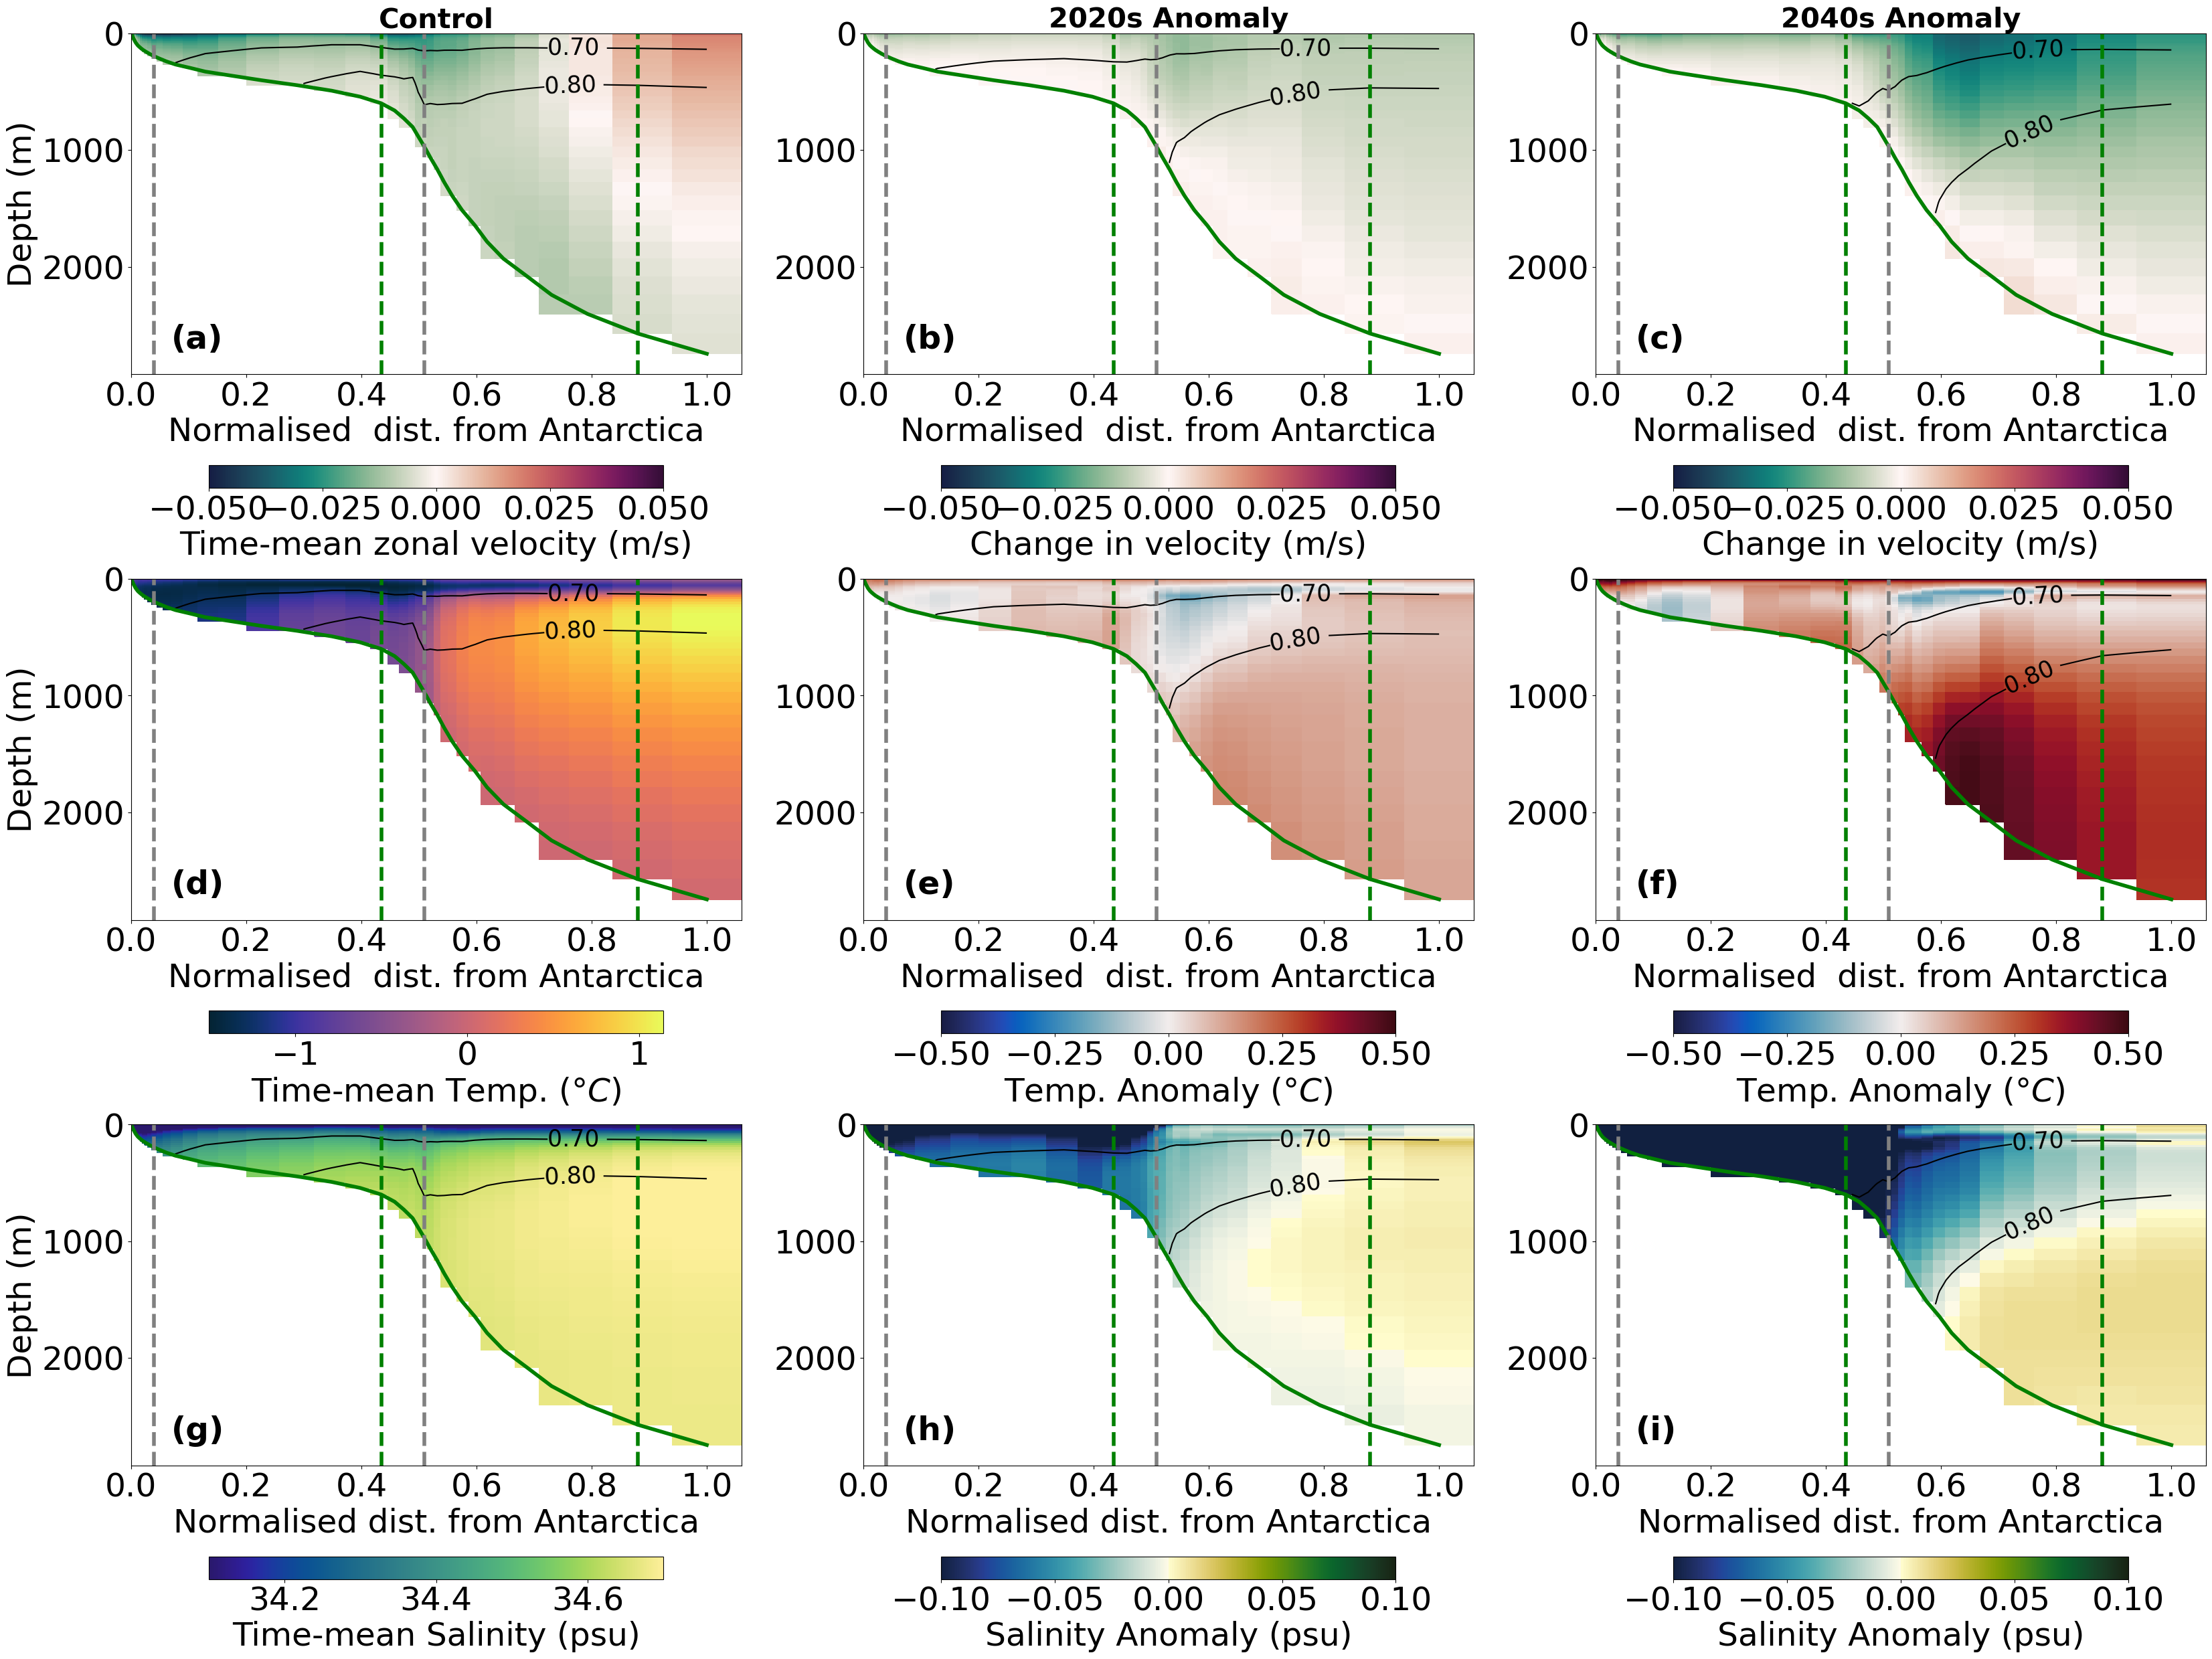

In [25]:
### new with control deviation -- checked!

fig, axs = plt.subplots(ncols = 3,nrows = 3, figsize=(40,30), facecolor='w', edgecolor='k')

#########

vmin_rho = 0.7
vmax_rho = 0.9
vmin_u = -0.05
vmax_u = 0.05
fontsize = 25
lw = 5
levels_rho = np.linspace(vmin_rho, vmax_rho,3)
levels_u = np.linspace(vmin_u, vmax_u,11)
manual_locations = [(0.775,200) ,(0.775,1000)]
color_clabel = 'k'

########## ZONAL VELOCITY

im1 = axs[0,0].pcolor(normalised_area_cumsum, st_ocean, u_mean_ctrl_0.mean('time').histogram_hu.values , vmin = vmin_u, vmax = vmax_u, cmap=cmocean.cm.curl)
cb2 = plt.colorbar(im1, ax=axs[0,0], fraction=0.05, pad=0.2,  orientation = 'horizontal')
cb2.set_label('Time-mean zonal velocity (m/s)')


im2 = axs[0,1].pcolor(normalised_area_cumsum, st_ocean, (u_mean_30.mean('time').histogram_hu.values - u_mean_ctrl_0.mean('time').histogram_hu.values), \
                    vmin = vmin_u, vmax = vmax_u, cmap=cmocean.cm.curl)
cb2 = plt.colorbar(im2, ax=axs[0,1], fraction=0.05, pad=0.2, orientation = 'horizontal')
cb2.set_label('Change in velocity (m/s)')

im3 = axs[0,2].pcolor(normalised_area_cumsum, st_ocean, (u_mean_50.mean('time').histogram_hu.values - u_mean_ctrl_0.mean('time').histogram_hu.values),  \
                    vmin = vmin_u, vmax = vmax_u, cmap=cmocean.cm.curl)
cb2 = plt.colorbar(im3, ax=axs[0,2], fraction=0.05, pad=0.2, orientation = 'horizontal')
cb2.set_label('Change in velocity (m/s)')


CS = axs[0,0].contour(normalised_area_cumsum, st_ocean, rho_mean_ctrl_0.mean('time').histogram_ht.values-1027,  levels = levels_rho , vmin=vmin_rho, vmax=vmax_rho, colors =color_clabel)
kwargs = {'inline_spacing' : 0, 'inline': True, 'use_clabeltext' : True, 'fontsize':fontsize, 'manual' : manual_locations}#, 'fontweight':'bold'}
axs[0,0].clabel(CS, CS.levels,fmt= fmt_rho, **kwargs)

CS = axs[0,1].contour(normalised_area_cumsum, st_ocean, rho_mean_30.mean('time').histogram_ht.values-1027,  levels = levels_rho ,vmin=vmin_rho, vmax=vmax_rho, colors = color_clabel)
axs[0,1].clabel(CS, CS.levels,fmt= fmt_rho,  **kwargs)

CS = axs[0,2].contour(normalised_area_cumsum, st_ocean, rho_mean_50.mean('time').histogram_ht.values-1027,  levels = levels_rho , vmin=vmin_rho, vmax=vmax_rho, colors = color_clabel)
axs[0,2].clabel(CS, CS.levels,fmt= fmt_rho,  **kwargs)
print(CS.levels)

axs[0,0].set_title('Control', fontweight = 'bold',fontsize = 30)
axs[0,1].set_title('2020s Anomaly', fontweight = 'bold',fontsize = 30)
axs[0,2].set_title('2040s Anomaly', fontweight = 'bold',fontsize = 30)

for i in range(3):
    axs[0,i].set_xlabel('Normalised  dist. from Antarctica')
    #axs[i].set_ylim([0,3000])
    axs[0,i].invert_yaxis()
    plot_topography_isobath(bins_isobath, axs[0,i])

####### temp

im1 = axs[1,0].pcolor(normalised_area_cumsum, st_ocean, T_mean_ctrl_0.mean('time').histogram_ht.values -273 , cmap=cmocean.cm.thermal)
cb2 = plt.colorbar(im1, ax=axs[1,0], fraction=0.05, pad=0.2, orientation = 'horizontal')
cb2.set_label('Time-mean Temp. ($\degree C$)')

im2 = axs[1,1].pcolor(normalised_area_cumsum, st_ocean,(T_mean_30.mean('time').histogram_ht.values - T_mean_ctrl_0.mean('time').histogram_ht.values), \
                    vmin = -0.5, vmax = 0.5, cmap=cmocean.cm.balance)
cb2 = plt.colorbar(im2, ax=axs[1,1], fraction=0.05, pad=0.2, orientation = 'horizontal')
cb2.set_label('Temp. Anomaly ($\degree C$)')

im3 = axs[1,2].pcolor(normalised_area_cumsum, st_ocean,(T_mean_50.mean('time').histogram_ht.values - T_mean_ctrl_0.mean('time').histogram_ht.values),  \
                    vmin = -0.5, vmax = 0.5, cmap=cmocean.cm.balance)
cb2 = plt.colorbar(im3, ax=axs[1,2], fraction=0.05, pad=0.2, orientation = 'horizontal')
cb2.set_label('Temp. Anomaly ($\degree C$)')

# temp
CS = axs[1,0].contour(normalised_area_cumsum, st_ocean, rho_mean_ctrl_0.mean('time').histogram_ht.values-1027,  levels = levels_rho , vmin=vmin_rho, vmax=vmax_rho,colors = color_clabel)
axs[1,0].clabel(CS, CS.levels,fmt= fmt_rho, **kwargs)

CS = axs[1,1].contour(normalised_area_cumsum, st_ocean, rho_mean_30.mean('time').histogram_ht.values-1027,  levels = levels_rho ,vmin=vmin_rho, vmax=vmax_rho,colors = color_clabel)
axs[1,1].clabel(CS, CS.levels,fmt= fmt_rho,  **kwargs)
print(CS.levels)

CS = axs[1,2].contour(normalised_area_cumsum, st_ocean, rho_mean_50.mean('time').histogram_ht.values-1027,  levels = levels_rho , vmin=vmin_rho, vmax=vmax_rho, colors = color_clabel)
axs[1,2].clabel(CS, CS.levels,fmt= fmt_rho,  **kwargs)
print(CS.levels)

for i in range(3):
    axs[1,i].set_xlabel('Normalised  dist. from Antarctica')
    #axs[i].set_ylim([0,3000])
    axs[1,i].invert_yaxis()
    plot_topography_isobath(bins_isobath, axs[1,i])

########## salinty
im1 = axs[2,0].pcolor(normalised_area_cumsum, st_ocean, S_mean_0.mean('time').histogram_ht.values, vmin=34.1, vmax = 34.7, cmap=cmocean.cm.haline)
cb2 = plt.colorbar(im1, ax=axs[2,0], fraction=0.05, pad=0.2, orientation = 'horizontal')
cb2.set_label('Time-mean Salinity (psu)')


im2 = axs[2,1].pcolor(normalised_area_cumsum, st_ocean, S_mean_30.mean('time').histogram_ht.values - S_mean_ctrl_0.mean('time').histogram_ht.values, vmin=-0.1, vmax = 0.1, cmap=cmocean.cm.delta)
cb2 = plt.colorbar(im2, ax=axs[2,1], fraction=0.05, pad=0.2, orientation = 'horizontal')
cb2.set_label('Salinity Anomaly (psu)')

im3 = axs[2,2].pcolor(normalised_area_cumsum, st_ocean, S_mean_50.mean('time').histogram_ht.values - S_mean_ctrl_0.mean('time').histogram_ht.values, vmin=-0.1, vmax = 0.1, cmap=cmocean.cm.delta)
cb2 = plt.colorbar(im3, ax=axs[2,2], fraction=0.05, pad=0.2, orientation = 'horizontal')
cb2.set_label('Salinity Anomaly (psu)')


CS = axs[2,0].contour(normalised_area_cumsum, st_ocean, rho_mean_ctrl_0.mean('time').histogram_ht.values-1027,  levels = levels_rho , vmin=vmin_rho, vmax=vmax_rho, colors = color_clabel)
axs[2,0].clabel(CS, CS.levels,fmt= fmt_rho, **kwargs)

CS = axs[2,1].contour(normalised_area_cumsum, st_ocean, rho_mean_30.mean('time').histogram_ht.values-1027,  levels = levels_rho ,vmin=vmin_rho, vmax=vmax_rho, colors = color_clabel)
axs[2,1].clabel(CS, CS.levels,fmt= fmt_rho,  **kwargs)
print(CS.levels)

CS = axs[2,2].contour(normalised_area_cumsum, st_ocean, rho_mean_50.mean('time').histogram_ht.values-1027,  levels = levels_rho , vmin=vmin_rho, vmax=vmax_rho, colors = color_clabel)
axs[2,2].clabel(CS, CS.levels,fmt= fmt_rho,  **kwargs)
print(CS.levels)
for i in range(3):
    axs[2,i].set_xlabel('Normalised dist. from Antarctica')
    #axs[i].set_ylim([0,3000])
    axs[2,i].invert_yaxis()
    plot_topography_isobath(bins_isobath, axs[2,i])
    axs[i,0].set_ylabel('Depth (m)')
    
axs[0,0].text(0.07,2700,'(a)', fontweight = 'bold')
axs[0,1].text(0.07,2700,'(b)', fontweight = 'bold')
axs[0,2].text(0.07,2700,'(c)', fontweight = 'bold')
axs[1,0].text(0.07,2700,'(d)', fontweight = 'bold')
axs[1,1].text(0.07,2700,'(e)', fontweight = 'bold')
axs[1,2].text(0.07,2700,'(f)', fontweight = 'bold')
axs[2,0].text(0.07,2700,'(g)', fontweight = 'bold')
axs[2,1].text(0.07,2700,'(h)', fontweight = 'bold')
axs[2,2].text(0.07,2700,'(i)', fontweight = 'bold')


#plt.tight_layout()

# Houvmoller plot for Fig. S2

In [11]:
expt

'01deg_jra55v13_ryf9091_qian_wthmp'

In [12]:
start_time='2110-01-01 00:00:00'
end_time='2159-12-31 00:00:00'


In [26]:
Vu_sum.load()

<xarray.DataArray 'histogram_hu' (st_ocean: 75, hu_bin: 75)> Size: 45kB
array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        7.72322352e+11, 7.09687544e+10, 4.92802978e+09],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        8.53498818e+11, 7.84280655e+10, 5.44600008e+09],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        9.43206785e+11, 8.66713367e+10, 6.01840813e+09],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        5.39262748e+13, 1.29612462e+13, 9.00021535e+11],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 3.76054780e+12, 9.01802824e+11],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 6.94801688e+11, 3.72446489e+11]])
Coordinates:
  * hu_bin   (hu_bin) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
Dimensions without coordinates: st_ocean

In [ ]:
u = cc.querying.getvar(expt, 'u', session, start_time=start_time, end_time=end_time, frequency='1 monthly')#, ncfile="ocean.nc")
u = u.sel(time=slice(start_time,end_time)).sel(yu_ocean=lat_slice)
u_mean_arr = []
for tt in range(600):#len(u.time)):
    u_sel = u.isel(time = tt)
    uV_sum = histogram(hu, bins = bins_isobath,\
                       dim = ['yu_ocean', 'xu_ocean'], weights = volume_u*u_sel)
    u_mean = uV_sum/Vu_sum
    u_mean.load()
    u_mean_arr.append(u_mean)

In [ ]:
u_houvmoller = xr.concat(u_mean_arr, dim = 'time')
u_houvmoller

In [83]:
u_houvmoller.to_netcdf('u_houvmoller_isobath.nc')

In [29]:
pwd

'/g/data/v45/qo9901/MW-perturb-ASC-data'

In [31]:
## load here
u_houvmoller = xr.open_mfdataset('/home/561/qo9901/MW-perturb-ASC/nc_files/u_houvmoller_isobath.nc')
u_houvmoller

<xarray.Dataset> Size: 27MB
Dimensions:       (hu_bin: 75, time: 600, st_ocean: 75)
Coordinates:
  * hu_bin        (hu_bin) float64 600B 0.5413 1.681 ... 5.511e+03 5.709e+03
Dimensions without coordinates: time, st_ocean
Data variables:
    histogram_hu  (time, st_ocean, hu_bin) float64 27MB dask.array<chunksize=(600, 75, 75), meta=np.ndarray>

In [32]:

isobath600m = u_houvmoller.hu_bin.where(u_houvmoller.hu_bin > 600).argmin(dim = 'hu_bin')
isobath750m = u_houvmoller.hu_bin.where(u_houvmoller.hu_bin > 750).argmin(dim = 'hu_bin')
isobath1000m = u_houvmoller.hu_bin.where(u_houvmoller.hu_bin > 1000).argmin(dim = 'hu_bin')
isobath1500m = u_houvmoller.hu_bin.where(u_houvmoller.hu_bin > 1500).argmin(dim = 'hu_bin')
isobath2000m = u_houvmoller.hu_bin.where(u_houvmoller.hu_bin > 2000).argmin(dim = 'hu_bin')
isobath2500m = u_houvmoller.hu_bin.where(u_houvmoller.hu_bin > 2500).argmin(dim = 'hu_bin')

isobath750m

<xarray.DataArray 'hu_bin' ()> Size: 8B
array(43)

In [33]:
ACoC_umin_idx = u_houvmoller.isel(st_ocean = 0).argmin(dim = 'hu_bin').histogram_hu.T
ASC_umin_idx = u_houvmoller.isel(st_ocean = 0).isel(hu_bin = slice(43,75)).argmin(dim = 'hu_bin').histogram_hu.T + 43

In [34]:
abs_u = abs(u_houvmoller.isel(st_ocean = 0)).load()

In [35]:
sign_contour = abs_u.argmin(dim = 'hu_bin').histogram_hu.T

In [37]:
sign_contour_na = sign_contour.where(sign_contour<60).dropna(dim = 'time')
sign_contour_na_val =[int(sign_contour_na[i])\
    for i in range(len(sign_contour_na.time))]


In [38]:
sign_contour_dist = normalised_area_cumsum[sign_contour_na_val]

In [39]:
ACoC_umin_dist = normalised_area_cumsum[ACoC_umin_idx]
ASC_umin_dist = normalised_area_cumsum[ASC_umin_idx]

In [40]:
sign_contour_time = sign_contour.time.where(sign_contour<60).dropna(dim = 'time')

In [42]:

isobath300m = u_houvmoller.hu_bin.where(u_houvmoller.hu_bin > 300).argmin(dim = 'hu_bin')
isobath200m = u_houvmoller.hu_bin.where(u_houvmoller.hu_bin > 200).argmin(dim = 'hu_bin')


In [43]:
from matplotlib import rc
rc('font', **{'size':25})
rc('text', usetex=False)
rc('xtick', labelsize=25) #20 
rc('ytick', labelsize=25) #20
rc('axes', titlesize=25)    # fontsize of the axes title
rc('axes', labelsize=25)

In [44]:
import cmocean

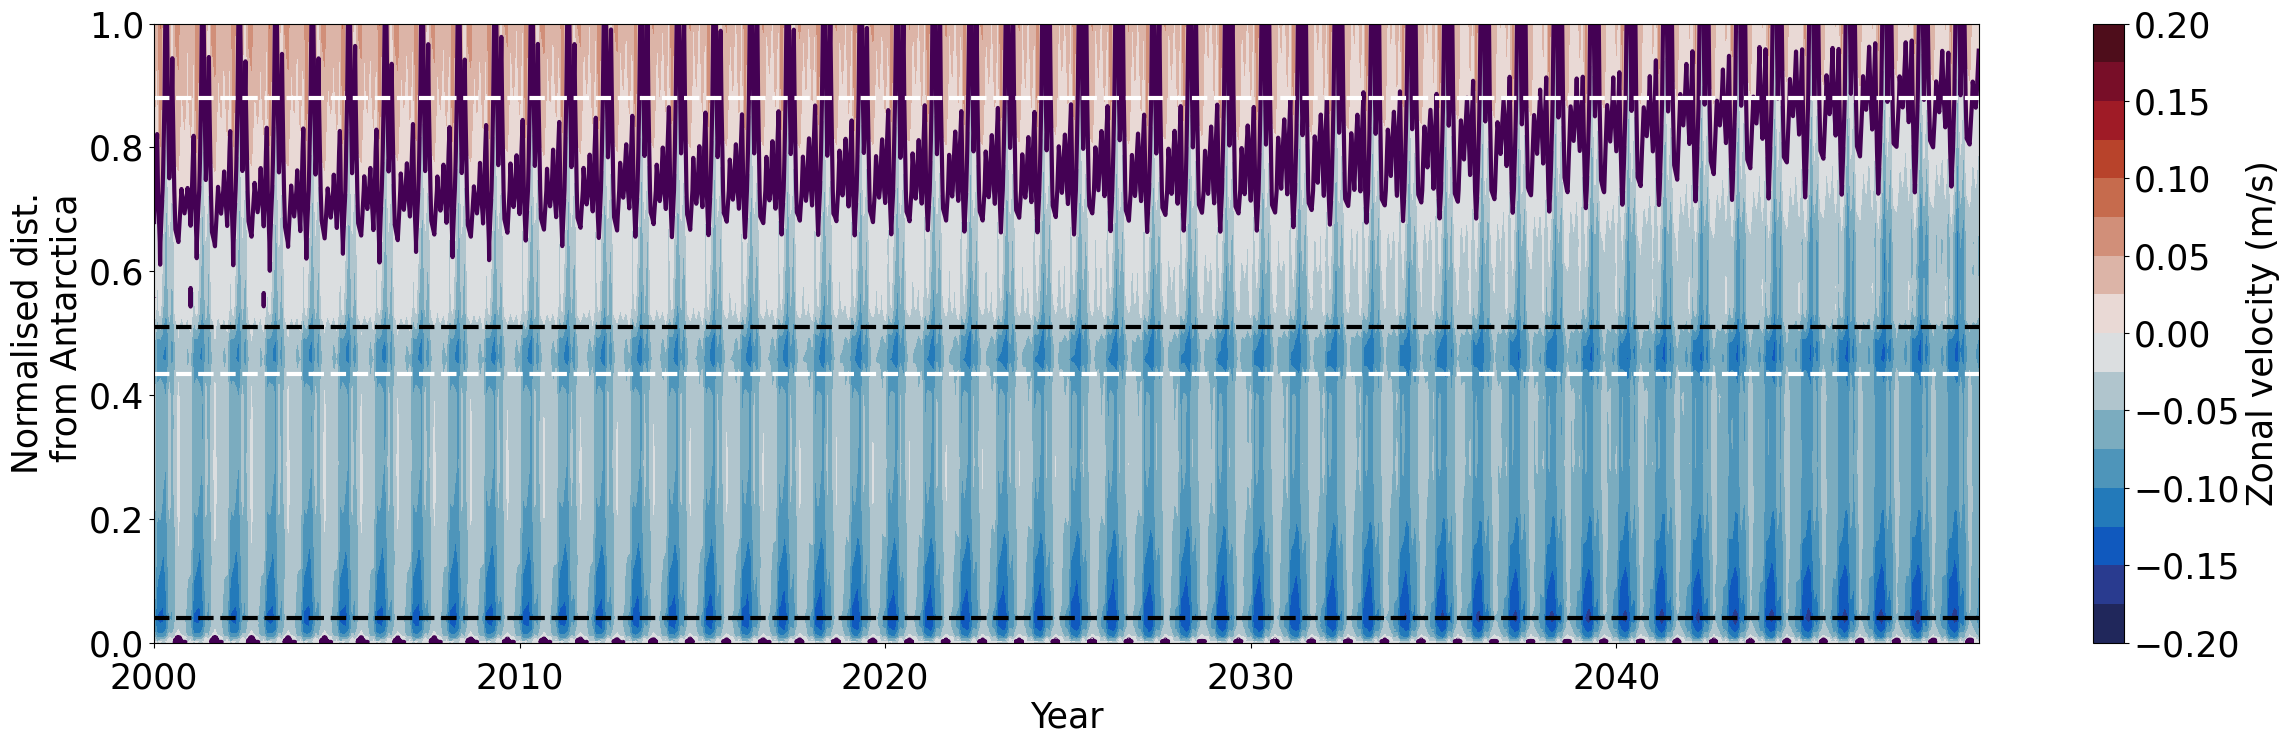

In [45]:
# FINAL HOUVMOLLER
fig, ax = plt.subplots( figsize = (25,8), sharex = True)
levels = np.arange(-0.2,0.225,0.025)
#plt.rcParams['xtick.major.pad']='8'
#plt.rcParams['ytick.major.pad']='8'

cmap = plt.contourf(u_houvmoller.time, normalised_area_cumsum,\
             u_houvmoller.isel(st_ocean = 0).sel(hu_bin = slice(0,3000)).\
                    histogram_hu.T, levels = levels, cmap = cmocean.cm.balance)
plt.contour(u_houvmoller.time, normalised_area_cumsum,\
            u_houvmoller.isel(st_ocean = 0).sel(hu_bin = slice(0,3000)).\
            histogram_hu.T, levels = [-0.0], c = 'k', linewidths  = 3)

plt.plot(u_houvmoller.time, np.ones(600)*normalised_area_cumsum[isobath600m.values].values, \
         c = 'w', lw  = 3, linestyle = 'dashed')
plt.plot(u_houvmoller.time, np.ones(600)*normalised_area_cumsum[isobath1000m.values].values, \
         c = 'k', lw  = 3, linestyle = 'dashed')

plt.plot(u_houvmoller.time, np.ones(600)*normalised_area_cumsum[isobath2500m.values].values, \
         c = 'w', lw  = 3, linestyle = 'dashed')


plt.plot(u_houvmoller.time, np.ones(600)*normalised_area_cumsum[isobath200m.values].values, \
         c = 'k', lw  = 3, linestyle = 'dashed')
#cmap = ax[1].imshow(u_houvmoller.isel(st_ocean = 0).sel(hu_bin = slice(0,3000)).histogram_hu.T,  cmap = cmocean.balance)
plt.colorbar(cmap, orientation = 'vertical', label = 'Zonal velocity (m/s)')
ax.set_xticks(u_houvmoller.time[::120])
ax.set_xticklabels(np.arange(2000,2050, 10))
ax.xaxis.set_tick_params(pad=10)
ax.set_ylabel('Normalised dist.\n from Antarctica')
ax.set_xlabel('Year')

plt.tight_layout()

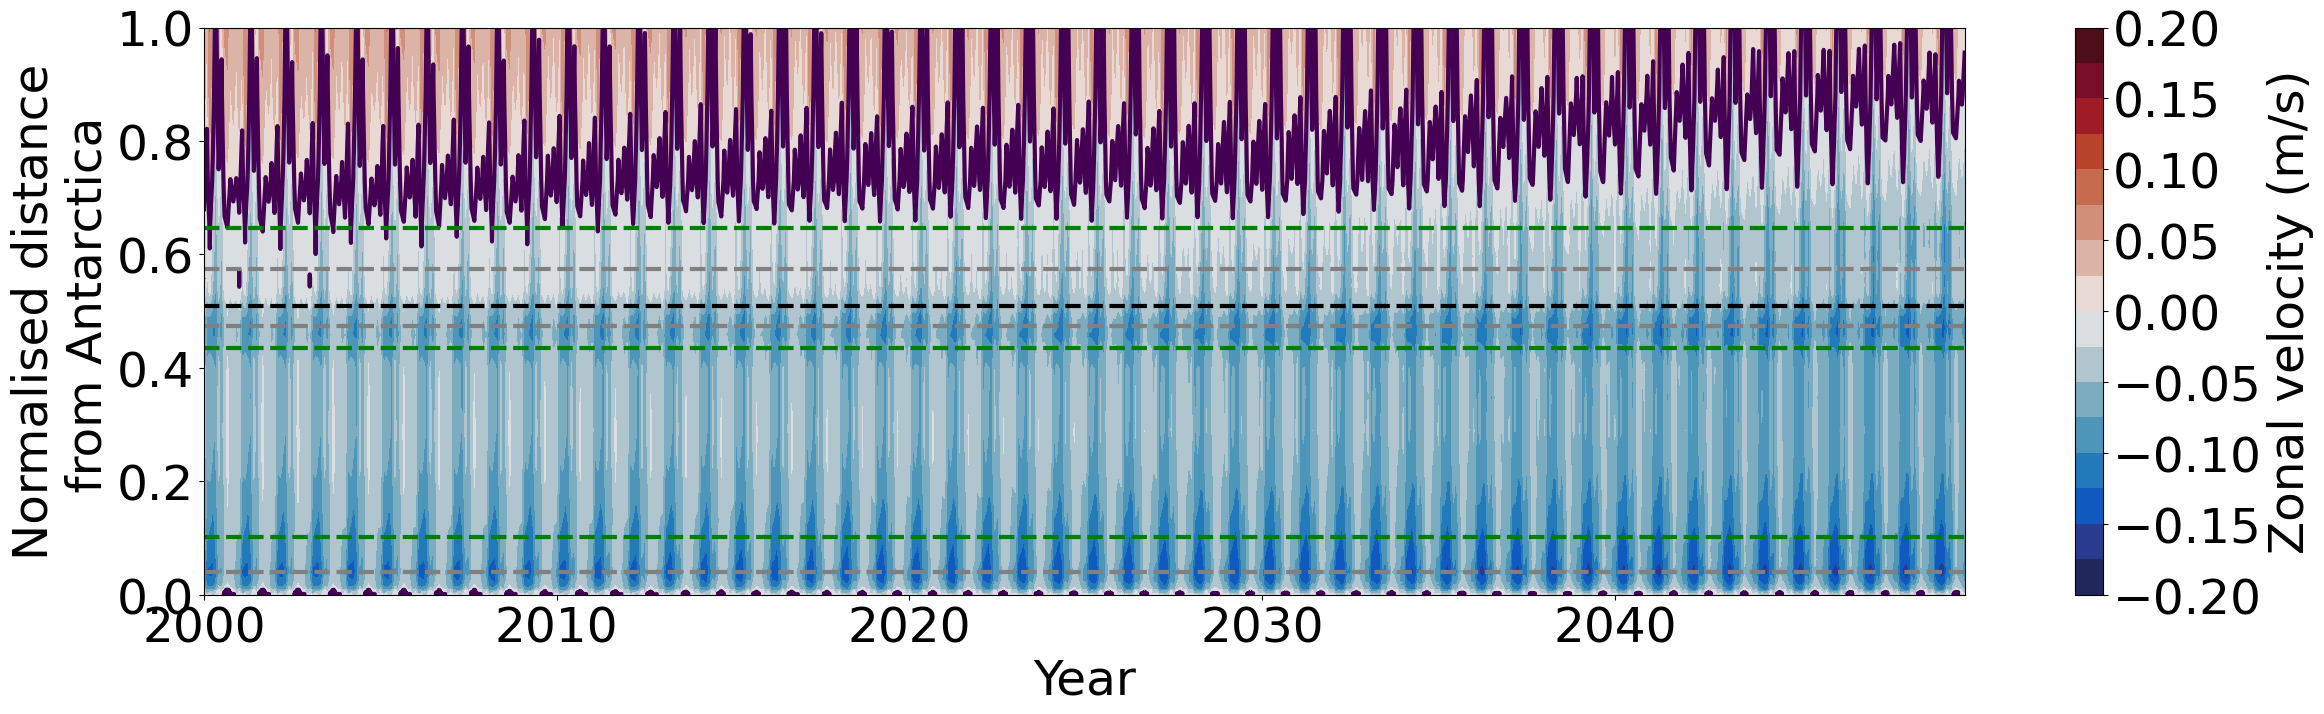

In [42]:
fig, ax = plt.subplots( figsize = (25,8), sharex = True)
levels = np.arange(-0.2,0.225,0.025)

cmap = plt.contourf(u_houvmoller.time, normalised_area_cumsum,\
             u_houvmoller.isel(st_ocean = 0).sel(hu_bin = slice(0,3000)).\
                    histogram_hu.T, levels = levels, cmap = cmocean.balance)
plt.contour(u_houvmoller.time, normalised_area_cumsum,\
            u_houvmoller.isel(st_ocean = 0).sel(hu_bin = slice(0,3000)).\
            histogram_hu.T, levels = [-0.0], c = 'k', linewidths  = 3)

#plt.plot(u_houvmoller.time, ASC_umin_dist,  c = 'k', lw  = 3, linestyle = 'dashed')
plt.plot(u_houvmoller.time, np.ones(600)*normalised_area_cumsum[isobath600m.values].values, \
         c = 'g', lw  = 3, linestyle = 'dashed')
plt.plot(u_houvmoller.time, np.ones(600)*normalised_area_cumsum[isobath750m.values].values, \
         c = 'gray', lw  = 3, linestyle = 'dashed')
plt.plot(u_houvmoller.time, np.ones(600)*normalised_area_cumsum[isobath1000m.values].values, \
         c = 'k', lw  = 3, linestyle = 'dashed')
plt.plot(u_houvmoller.time, np.ones(600)*normalised_area_cumsum[isobath1500m.values].values, \
         c = 'gray', lw  = 3, linestyle = 'dashed')
plt.plot(u_houvmoller.time, np.ones(600)*normalised_area_cumsum[isobath2500m.values].values, \
         c = 'g', lw  = 3, linestyle = 'dashed')


plt.plot(u_houvmoller.time, np.ones(600)*normalised_area_cumsum[isobath300m.values].values, \
         c = 'g', lw  = 3, linestyle = 'dashed')
plt.plot(u_houvmoller.time, np.ones(600)*normalised_area_cumsum[isobath200m.values].values, \
         c = 'gray', lw  = 3, linestyle = 'dashed')
#cmap = ax[1].imshow(u_houvmoller.isel(st_ocean = 0).sel(hu_bin = slice(0,3000)).histogram_hu.T,  cmap = cmocean.balance)
plt.colorbar(cmap, orientation = 'vertical', label = 'Zonal velocity (m/s)')
ax.set_xticks(u_houvmoller.time[::120])
ax.set_xticklabels(np.arange(2000,2050, 10))
ax.set_ylabel('Normalised distance\n from Antarctica')
ax.set_xlabel('Year')

plt.tight_layout()

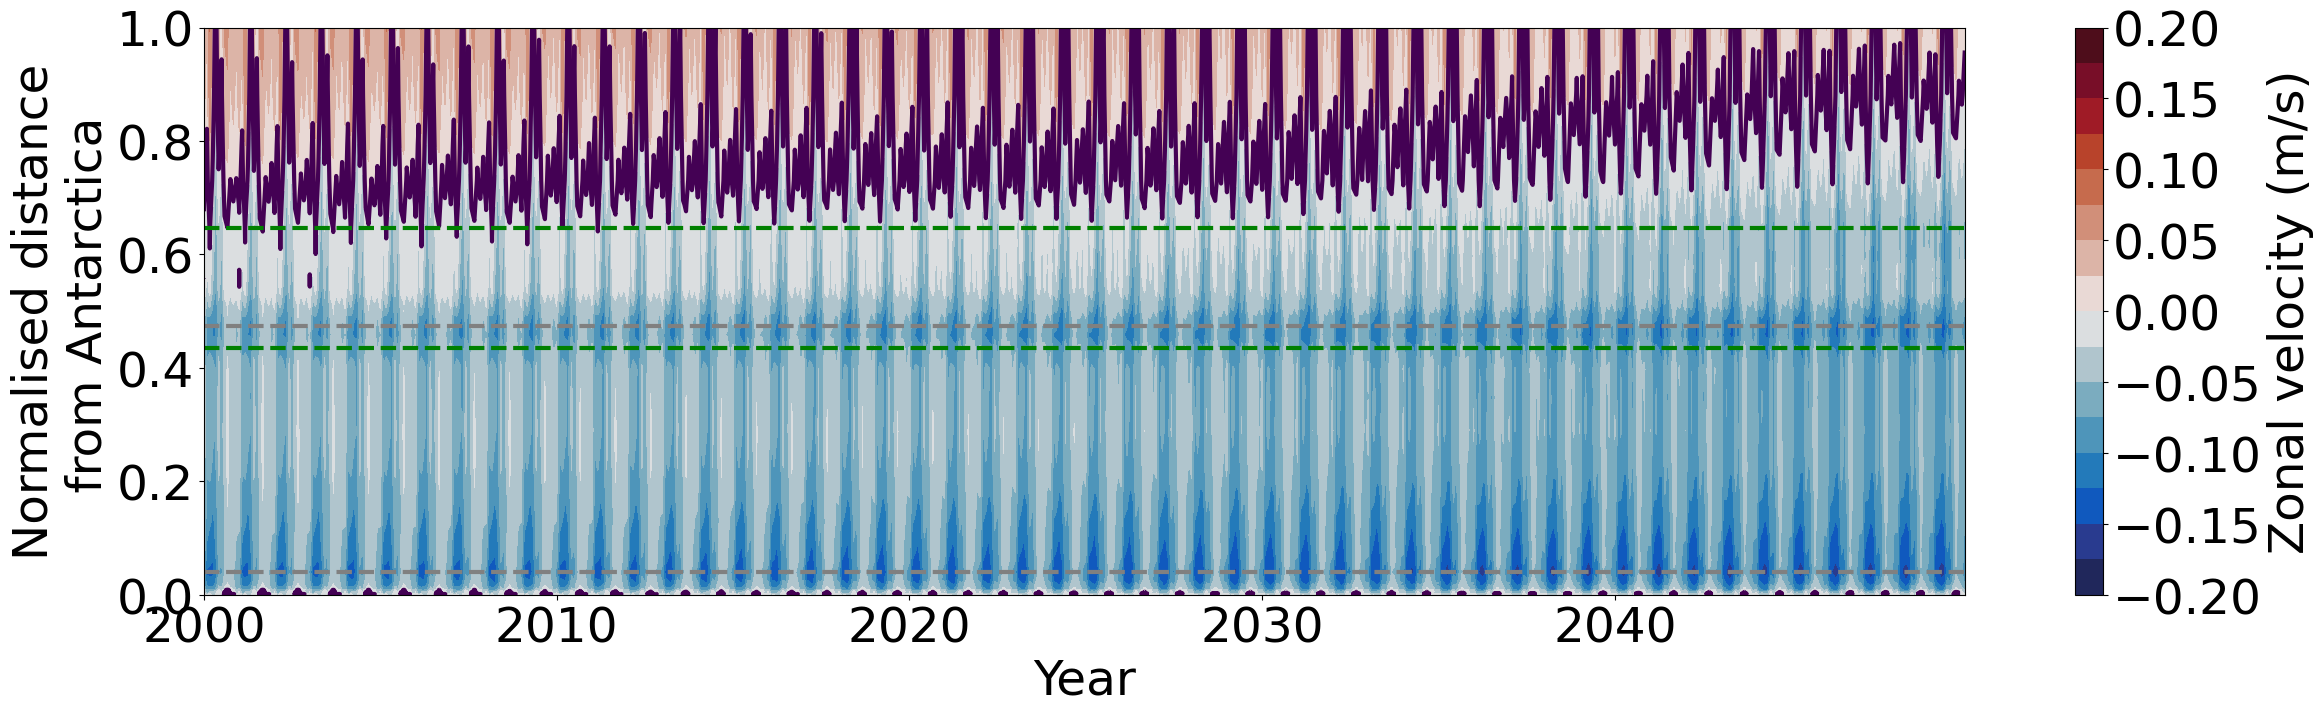

In [43]:
fig, ax = plt.subplots( figsize = (25,8), sharex = True)
levels = np.arange(-0.2,0.225,0.025)

cmap = plt.contourf(u_houvmoller.time, normalised_area_cumsum,\
             u_houvmoller.isel(st_ocean = 0).sel(hu_bin = slice(0,3000)).\
                    histogram_hu.T, levels = levels, cmap = cmocean.balance)
plt.contour(u_houvmoller.time, normalised_area_cumsum,\
            u_houvmoller.isel(st_ocean = 0).sel(hu_bin = slice(0,3000)).\
            histogram_hu.T, levels = [-0.0], c = 'k', linewidths  = 3)

#plt.plot(u_houvmoller.time, ASC_umin_dist,  c = 'k', lw  = 3, linestyle = 'dashed')
plt.plot(u_houvmoller.time, np.ones(600)*normalised_area_cumsum[isobath600m.values].values, \
         c = 'g', lw  = 3, linestyle = 'dashed')
plt.plot(u_houvmoller.time, np.ones(600)*normalised_area_cumsum[isobath750m.values].values, \
         c = 'gray', lw  = 3, linestyle = 'dashed')

plt.plot(u_houvmoller.time, np.ones(600)*normalised_area_cumsum[isobath2000m.values].values, \
         c = 'g', lw  = 3, linestyle = 'dashed')

plt.plot(u_houvmoller.time, np.ones(600)*normalised_area_cumsum[isobath200m.values].values, \
         c = 'gray', lw  = 3, linestyle = 'dashed')
#cmap = ax[1].imshow(u_houvmoller.isel(st_ocean = 0).sel(hu_bin = slice(0,3000)).histogram_hu.T,  cmap = cmocean.balance)
plt.colorbar(cmap, orientation = 'vertical', label = 'Zonal velocity (m/s)')
ax.set_xticks(u_houvmoller.time[::120])
ax.set_xticklabels(np.arange(2000,2050, 10))
ax.set_ylabel('Normalised distance\n from Antarctica')
ax.set_xlabel('Year')

plt.tight_layout()